In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sb
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [5]:
file_path= r"C:\Users\subha\Desktop\AgriSage\Crop_Recommendation.csv"
raw_data= pd.read_csv (file_path)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
a1 = raw_data.copy()

In [8]:
target = 'Crop'

In [9]:
features = a1.columns[:-1]
features

Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity',
       'pH_Value', 'Rainfall'],
      dtype='object')

The Interquartile Range (IQR) method is a common statistical technique used to identify and handle outliers in a dataset. The IQR is the range between the first quartile (Q1) and the third quartile (Q3) of the dataset.

In [10]:
Q1= a1[features].quantile(0.25)
Q3 = a1[features].quantile(0.75)
IQR = Q3 - Q1 


print('25th percentile of the given data is \n', Q1)
print('75th percentile of the given data is \n', Q3)
print('Interquartile range is\n', IQR)

25th percentile of the given data is 
 Nitrogen       21.000000
Phosphorus     28.000000
Potassium      20.000000
Temperature    22.769375
Humidity       60.261953
pH_Value        5.971693
Rainfall       64.551686
Name: 0.25, dtype: float64
75th percentile of the given data is 
 Nitrogen        84.250000
Phosphorus      68.000000
Potassium       49.000000
Temperature     28.561654
Humidity        89.948771
pH_Value         6.923643
Rainfall       124.267508
Name: 0.75, dtype: float64
Interquartile range is
 Nitrogen       63.250000
Phosphorus     40.000000
Potassium      29.000000
Temperature     5.792279
Humidity       29.686818
pH_Value        0.951950
Rainfall       59.715822
dtype: float64


In [11]:
lower_bound= Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('lower bound of the given data is \n', lower_bound)
print('upper bound of the given data is \n', upper_bound)


lower bound of the given data is 
 Nitrogen      -73.875000
Phosphorus    -32.000000
Potassium     -23.500000
Temperature    14.080956
Humidity       15.731726
pH_Value        4.543768
Rainfall      -25.022047
dtype: float64
upper bound of the given data is 
 Nitrogen       179.125000
Phosphorus     128.000000
Potassium       92.500000
Temperature     37.250073
Humidity       134.478998
pH_Value         8.351567
Rainfall       213.841241
dtype: float64


In [12]:
outliers = (a1[features] < lower_bound) | (a1[features] > upper_bound)

a1_no_outliers = a1[~outliers.any(axis=1)]

a1_no_outliers.reset_index(inplace=True, drop=True)

# Display the cleaned data
a1_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     1768 non-null   int64  
 1   Phosphorus   1768 non-null   int64  
 2   Potassium    1768 non-null   int64  
 3   Temperature  1768 non-null   float64
 4   Humidity     1768 non-null   float64
 5   pH_Value     1768 non-null   float64
 6   Rainfall     1768 non-null   float64
 7   Crop         1768 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 110.6+ KB


In [13]:
a1_no_outliers[target].value_counts()

Crop
Banana         100
Lentil         100
Jute           100
Cotton         100
Muskmelon      100
Watermelon     100
Maize          100
Pomegranate    100
Coffee         100
Blackgram      100
MungBean       100
PigeonPeas     100
KidneyBeans    100
Mango           98
Coconut         85
Orange          83
MothBeans       58
ChickPea        58
Papaya          54
Rice            32
Name: count, dtype: int64

In [14]:
def dist_plot(data, feature_list):
    n_cols= 2 
    n_rows = int(np.ceil(len(feature_list)/n_cols)) 
    # Creating figure
    fig = plt.figure(figsize=(16, 4*n_rows))
    outer = GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.3)

    for i in range(len(feature_list)):
        inner = GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                                 wspace=0.1, hspace=0.1, height_ratios=(0.15, 0.85))
        ax_box= plt.Subplot(fig, inner[0])
        sb.boxplot(data=data, x=feature_list[i], color='lightblue', ax=ax_box)
        ax_box.set_xlabel('')
        fig.add_subplot(ax_box)

        mean_value = data[feature_list[i]].mean()
        median_value = data[feature_list[i]].median()
        ax_hist = plt.Subplot(fig, inner[1])
        sb.histplot(data=data, x=feature_list[i], kde=True, ax=ax_hist)
        ax_hist.axvline(mean_value, color='green', linestyle='dotted', linewidth=2, label='Mean')
        ax_hist.axvline(median_value, color='purple', linestyle='dotted', linewidth=2, label='Median')
        ax_hist.legend(loc='lower right', fontsize=10)

        # Calculating skewness and kurtosis
        skewness = data[feature_list[i]].skew()
        kurt = data[feature_list[i]].kurt()
        if skewness < 0:
            x=0.25
        else:
            x=0.95
        # Adding skewness and kurtosis as text on the histogram plot
        ax_hist.text(x, 0.85, f"Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}", 
                         transform=ax_hist.transAxes, verticalalignment='top', horizontalalignment='right',
                         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'),
                    fontsize=10)
        fig.add_subplot(ax_hist)
    plt.tight_layout()
    plt.show(block=False)

C:\Users\subha\AppData\Local\Temp\ipykernel_16180\2722901249.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


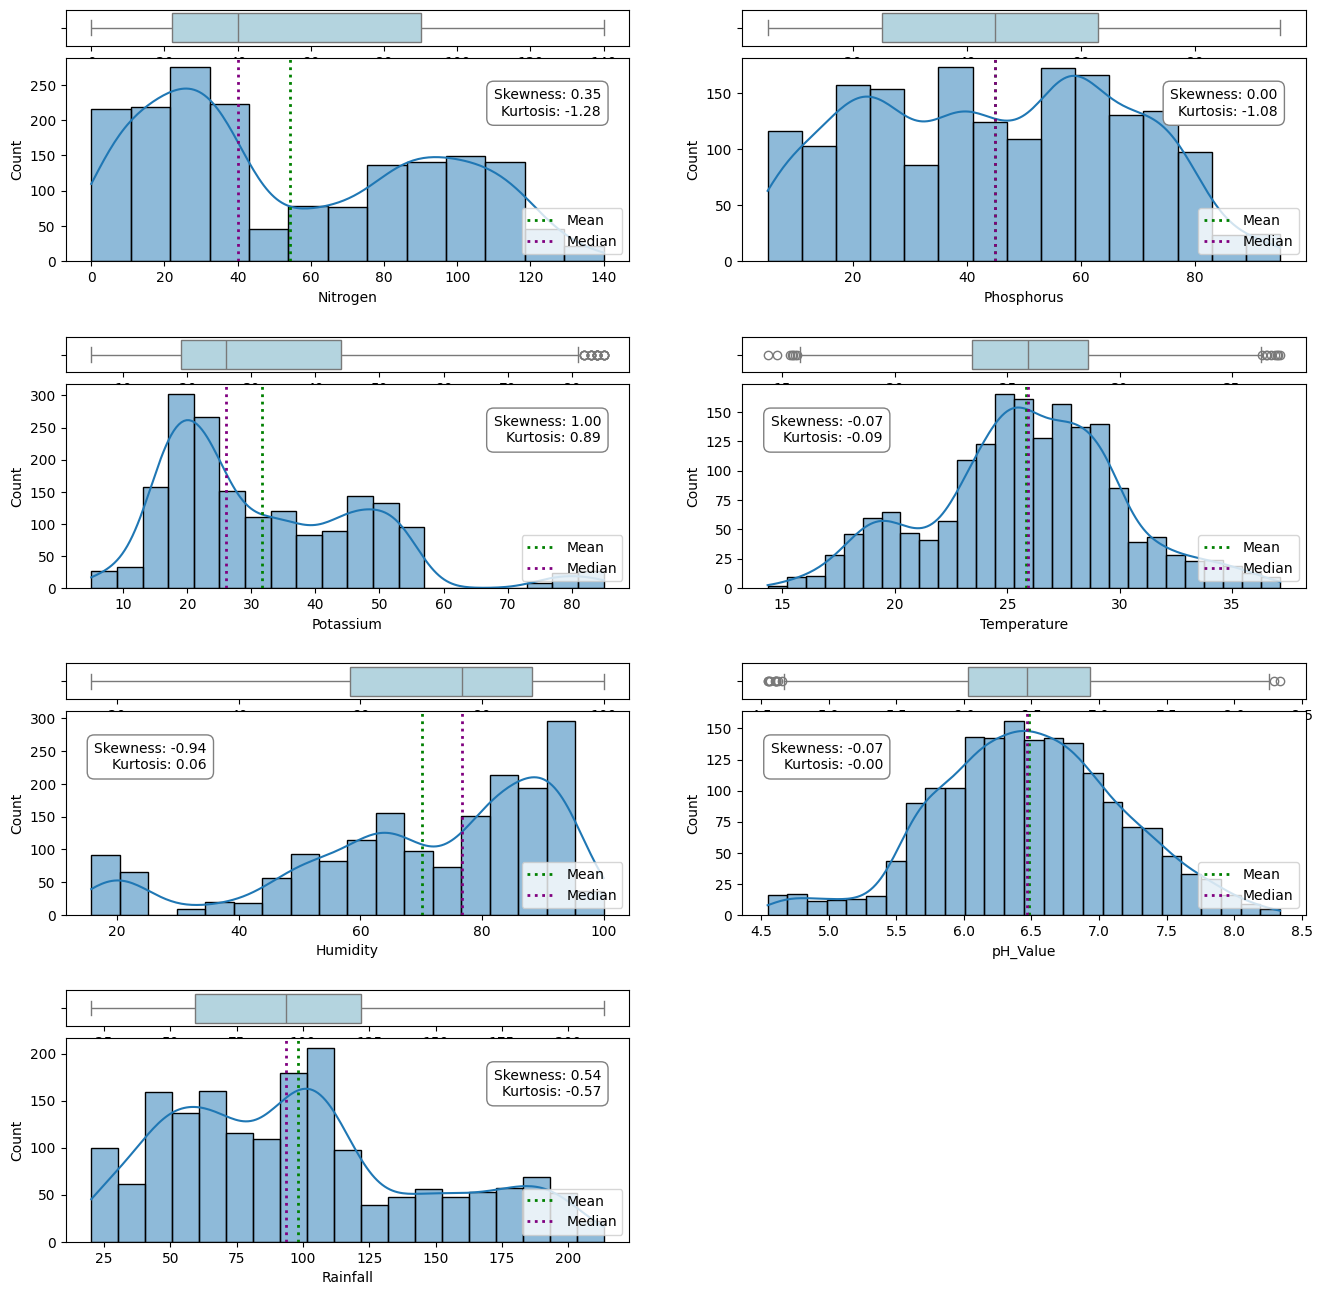

In [15]:
dist_plot(a1_no_outliers, features)


In [16]:
def plot_counts(data, features, hue=None):
    n_cols = 2 
    n_rows = int(np.ceil(len(features)/n_cols)) 

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, feature in enumerate(features):
        #bar_container = axes[i].bar(df[feature].value_counts().index, df[feature].value_counts().values)
        sb.countplot(
        data = data,
        x = feature,
        palette = 'Paired',
        hue = hue,
        ax = axes[i]
        )
        for p in axes[i].patches:
            label = p.get_height()
            x = p.get_x() + p.get_width() / 2 # Width of the plot
            y = p.get_height() # Height of the plot
            
            rotation = 0
            if hue is not None:
                rotation = 30  # Rotate annotations by 30 degrees if hue is not None

    axes[i].annotate(
        '{:.0f}'.format(label),
        (x, y),
        ha = 'center',
        va = 'center',
        size = 12,
        xytext = (0, 5),
        textcoords = 'offset points',
        rotation = rotation
    )
    axes[i].set(ylabel='Count', title=feature, xlabel='')
    axes[i].tick_params(axis='x', rotation=30)

    # If the number of features is odd, remove the empty subplot
    if len(features) % 2 != 0:
        fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

C:\Users\subha\AppData\Local\Temp\ipykernel_16180\1976827825.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(


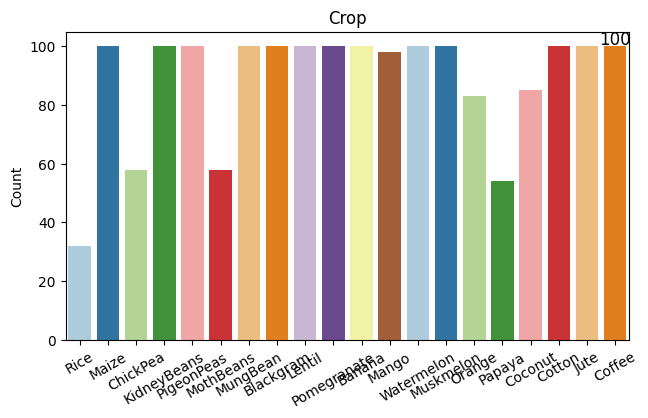

In [17]:
plot_counts(a1_no_outliers, [target])

In [18]:
print (a1.head())

   Nitrogen  Phosphorus  Potassium  Temperature   Humidity  pH_Value  \
0        90          42         43    20.879744  82.002744  6.502985   
1        85          58         41    21.770462  80.319644  7.038096   
2        60          55         44    23.004459  82.320763  7.840207   
3        74          35         40    26.491096  80.158363  6.980401   
4        78          42         42    20.130175  81.604873  7.628473   

     Rainfall  Crop  
0  202.935536  Rice  
1  226.655537  Rice  
2  263.964248  Rice  
3  242.864034  Rice  
4  262.717340  Rice  


Transformed Data:
   Nitrogen  Phosphorus  Potassium  Temperature  Humidity  pH_Value  \
0        90    3.737670   3.761200     3.038779  4.406753  6.502985   
1        85    4.060443   3.713572     3.080554  4.386014  7.038096   
2        60    4.007333   3.784190     3.135688  4.410623  7.840207   
3        74    3.555348   3.688879     3.276809  4.384004  6.980401   
4        78    3.737670   3.737670     3.002220  4.401889  7.628473   

     Rainfall  Crop  
0  202.935536  Rice  
1  226.655537  Rice  
2  263.964248  Rice  
3  242.864034  Rice  
4  262.717340  Rice  


C:\Users\subha\AppData\Local\Temp\ipykernel_16180\2722901249.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


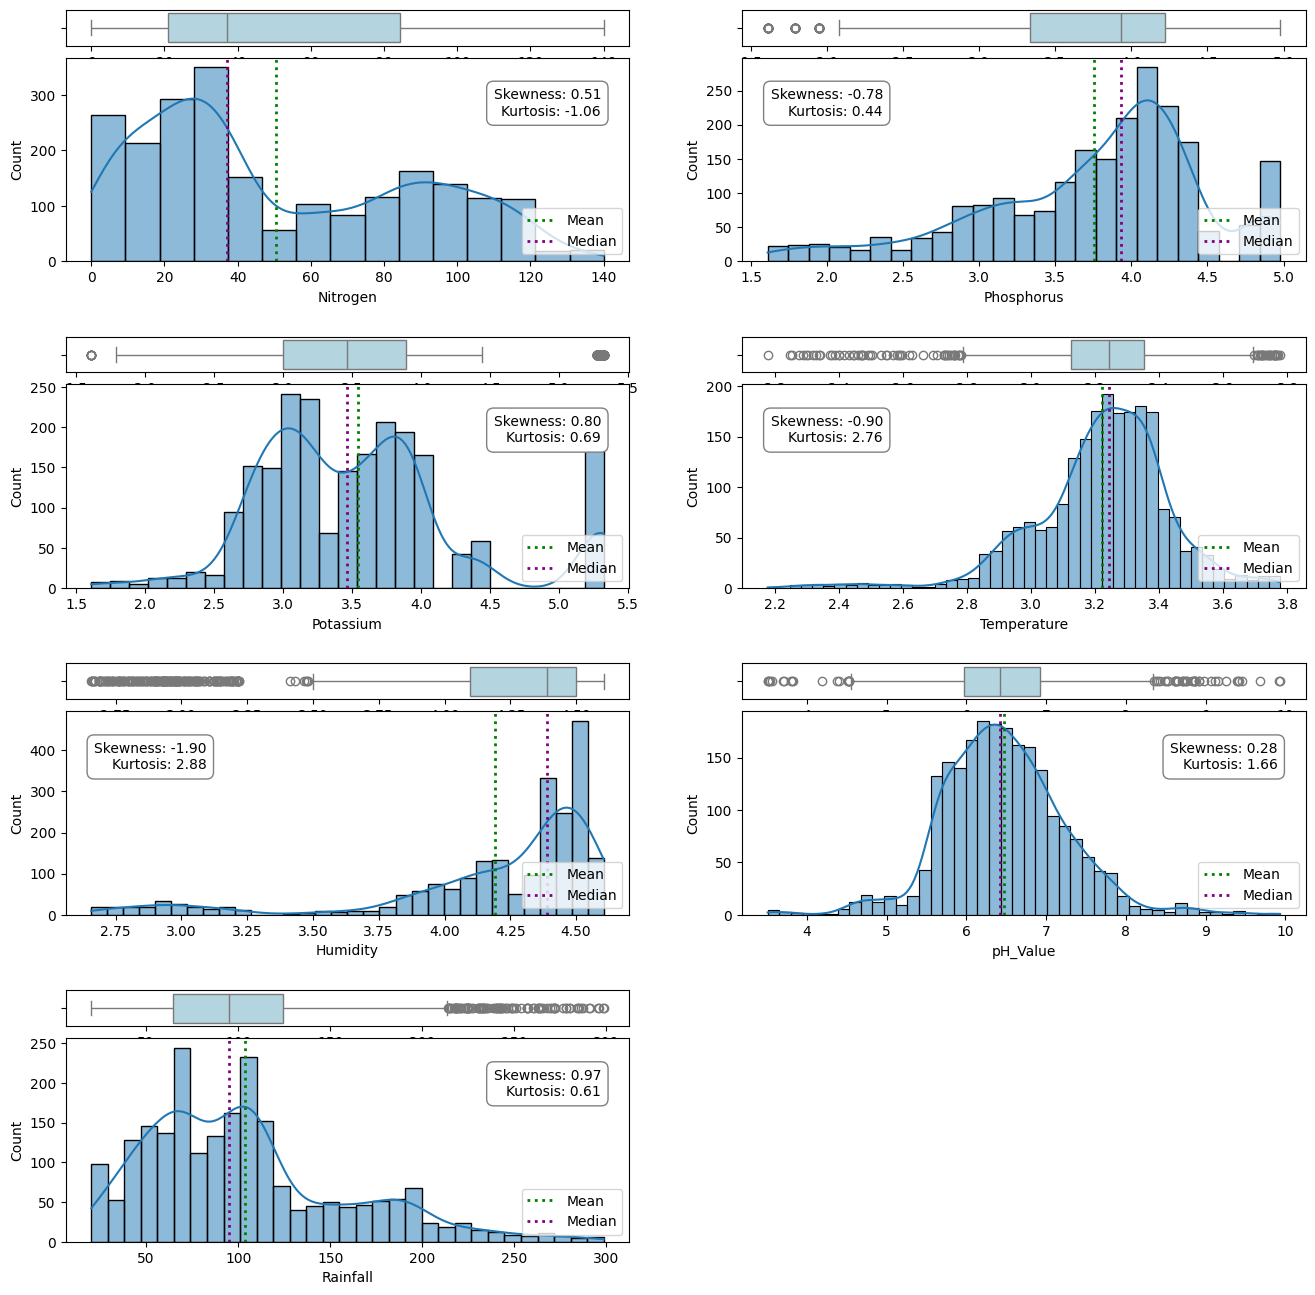

In [19]:
columns_to_transform = ['Potassium','Phosphorus','Temperature','Humidity']
# Replace zeros with a small number (e.g., 1e-6) or filter them out
a1[columns_to_transform] = a1[columns_to_transform].replace(0, np.nan)
a1[columns_to_transform] = a1[columns_to_transform].apply(np.log)
# Display the first few rows of the transformed dataset
print("Transformed Data:")
print(a1.head())
dist_plot(a1, features)

In [20]:
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer

In [21]:
def transformation_method(data, feature, target):
    # Check if the data object actually has any data in it
    empty = data is None or data.empty
    if empty:
        print("The data object is empty or not provided.")
        return
    
    # Ensure the target is categorical
    if not pd.api.types.is_categorical_dtype(data[target]):
        data[target] = pd.Categorical(data[target])
        
    fig, axes = plt.subplots(2, 3, figsize=(12, 9))  # Adjusted for an additional plot

    axes = axes.flatten()

    # Hide unused subplot axes
    for ax in axes[6:]:
        ax.axis('off')
        
    # Calculate skewness
    # Original Distribution of the feature
    sb.histplot(data[feature], kde=True, bins=30, hue=target, palette='viridis', ax=axes[0])
    axes[0].set_title(f'Original {feature} Distribution \n (Skew: {data[feature].skew():.5f})', fontsize=10)
    axes[0].set_xlabel(feature, fontsize=10)
    axes[0].set_ylabel('Frequency', fontsize=10)

    # Log Transformed feature
    data['Log_'+feature] = np.log(data[feature])
    sb.histplot(data['Log_'+feature], kde=True, bins=30, color='orange', ax=axes[1])
    axes[1].set_title(f"Log Transformed {feature} \n (Skew: {data['Log_'+feature].skew():.5f})", fontsize=10)
    axes[1].set_xlabel(f'Log of {feature}', fontsize=10)
    axes[1].set_ylabel('Frequency', fontsize=10)

    # Square Root Transformed feature
    data['Sqrt_'+feature] = np.sqrt(data[feature])
    sb.histplot(data['Sqrt_'+feature], kde=True, bins=30, color='blue', ax=axes[2])
    axes[2].set_title(f"Square Root Transformed {feature} \n (Skew: {data['Sqrt_'+feature].skew():.5f})", fontsize=10)
    axes[2].set_xlabel(f'Square Root of {feature}', fontsize=10)
    axes[2].set_ylabel('Frequency', fontsize=10)
    
    # Box-Cox Transformed feature
    # Applying Box-Cox Transformation after checking all values are positive
    if (data[feature] <= 0).any():
        # Shift the values to make them positive
        shift_value = abs(data[feature].min()) + 1
        data[feature] += shift_value
        print(f"Values of {feature} were shifted to make them positive.")
    data['BoxCox_'+feature], _ = boxcox(data[feature])
    sb.histplot(data['BoxCox_'+feature], kde=True, bins=30, color='red', ax=axes[3])
    axes[3].set_title(f"Box-Cox Transformed {feature} \n Skew: {data['BoxCox_'+feature].skew():.5f})", fontsize=10)
    axes[3].set_xlabel(f'Box-Cox of {feature}', fontsize=10)
    axes[3].set_ylabel('Frequency', fontsize=10)

    # Yeo-Johnson Transformed feature
    # Applying Yeo-Johnson Transformation
    data['YeoJohnson_'+feature], _ = yeojohnson(data[feature])
    sb.histplot(data['YeoJohnson_'+feature], kde=True, bins=30, color='purple', ax=axes[4])
    axes[4].set_title(f"Yeo-Johnson Transformed {feature} \n (Skew: {data['YeoJohnson_'+feature].skew():.5f})", fontsize=10)
    axes[4].set_xlabel(f'Yeo-Johnson of {feature}', fontsize=10)
    axes[4].set_ylabel('Frequency', fontsize=10)

    # Quantile Transformed feature (Normal Distribution)
    # Applying Quantile Transformation to follow a normal distribution
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    data['Quantile_'+feature] = quantile_transformer.fit_transform(data[feature].values.reshape(-1, 1)).flatten()
    sb.histplot(data['Quantile_'+feature], kde=True, bins=30, color='green', ax=axes[5])
    axes[5].set_title(f"Quantile Transformed {feature} (Normal Distn, \n Skew: {data['Quantile_'+feature].skew():.5f})", fontsize=10)
    axes[5].set_xlabel(f'Quantile Transformed {feature}', fontsize=10)
    axes[5].set_ylabel('Frequency', fontsize=10)


    plt.tight_layout(pad=3.0)
    plt.show()



C:\Users\subha\AppData\Local\Temp\ipykernel_16180\3945456284.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(data[target]):


ValueError: The following variable cannot be assigned with wide-form data: `hue`

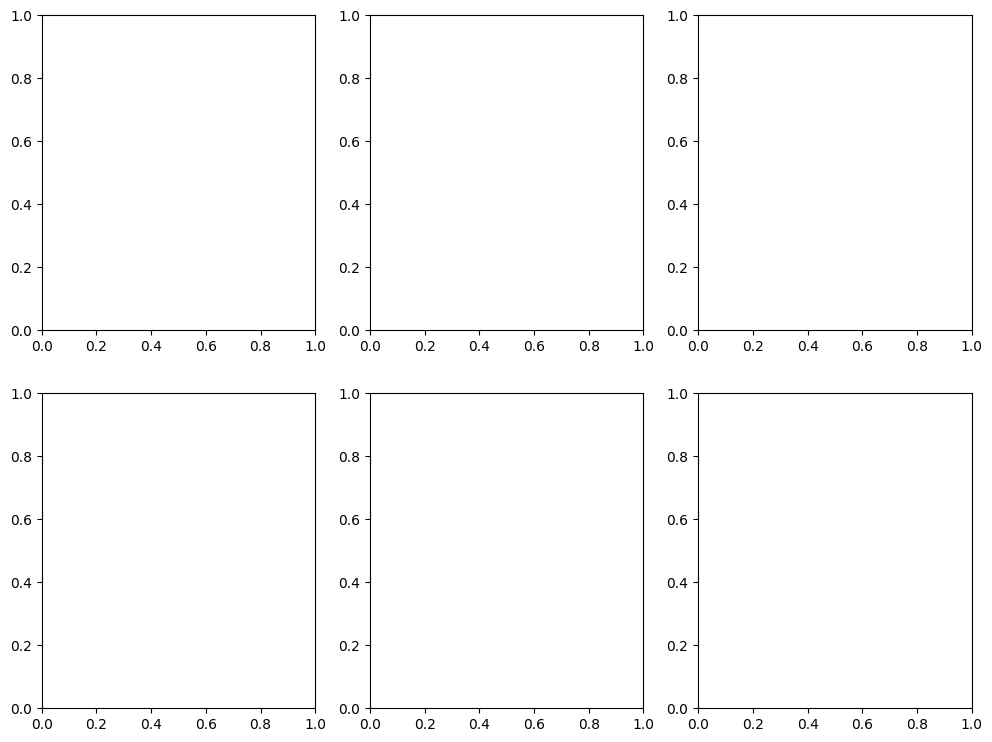

In [22]:
transformation_method(a1, features[0], 'Crop')

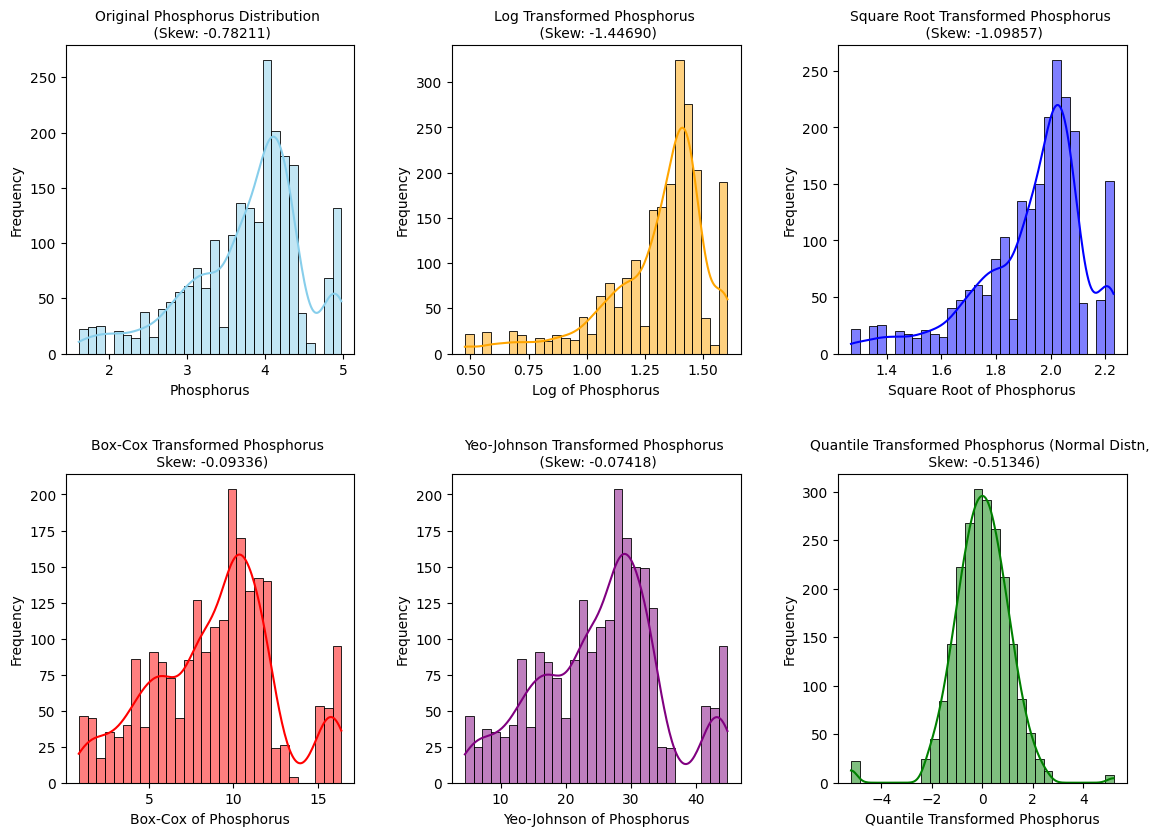

In [ ]:
transformation_method(a1, features[1])

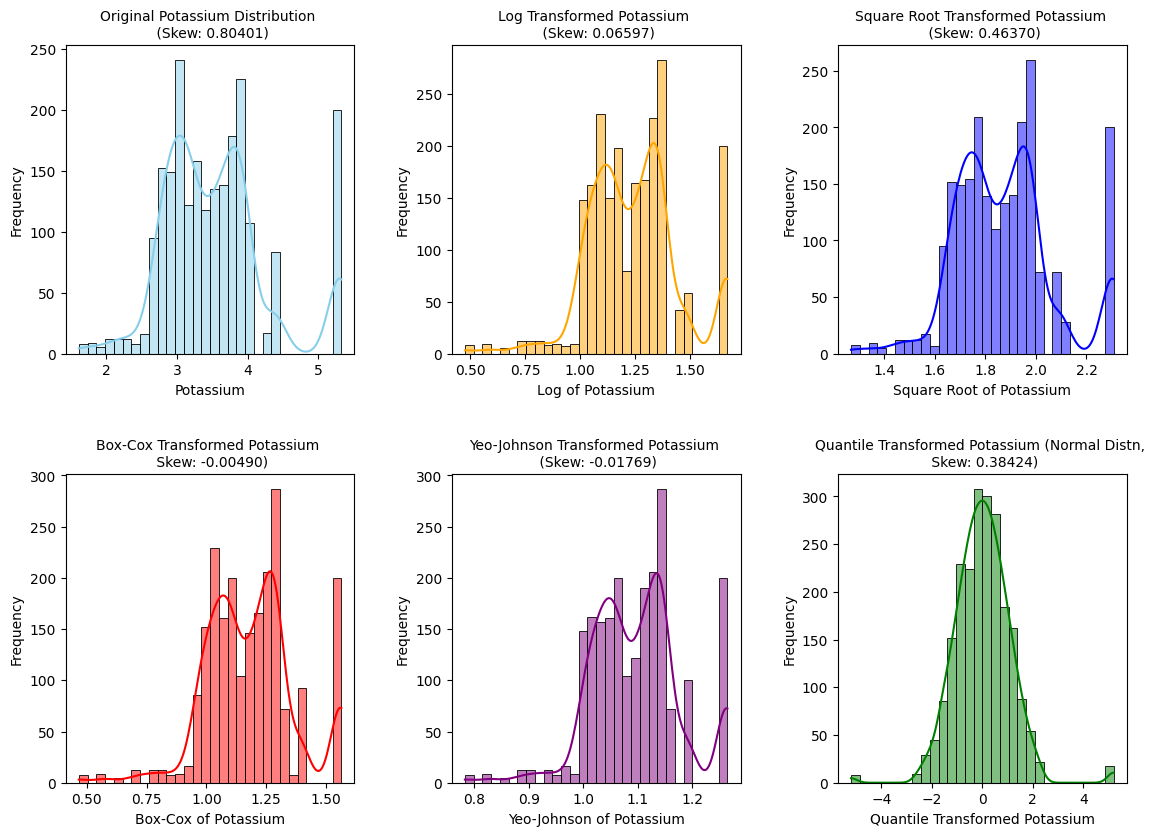

In [ ]:
transformation_method(a1, features[2])

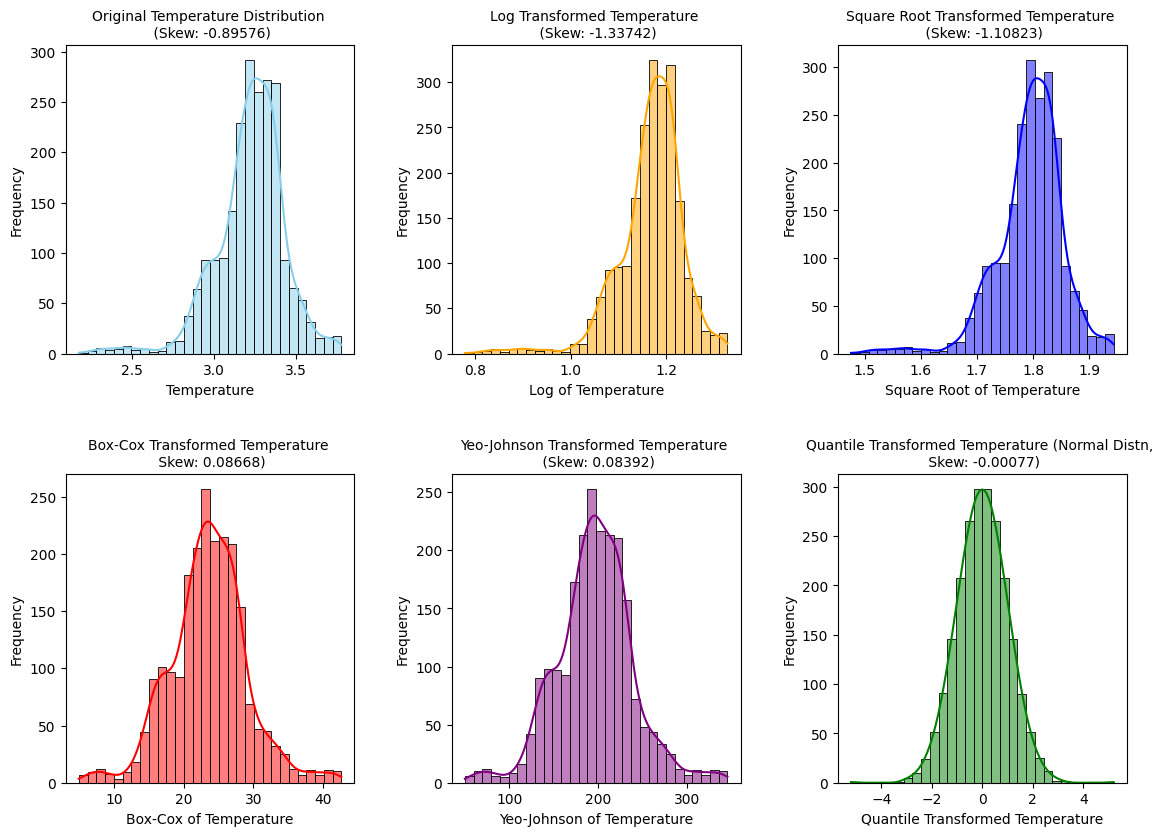

In [ ]:
transformation_method(a1, features[3])

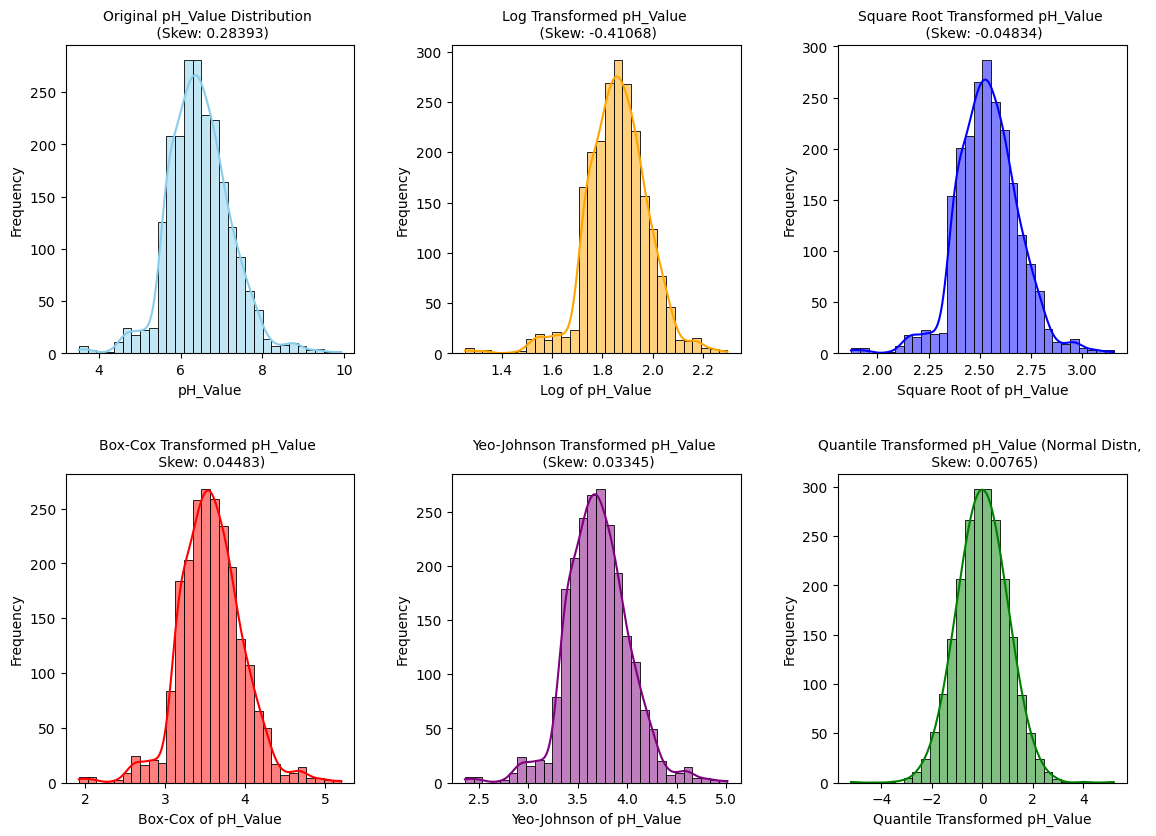

In [ ]:
transformation_method(a1, features[5])

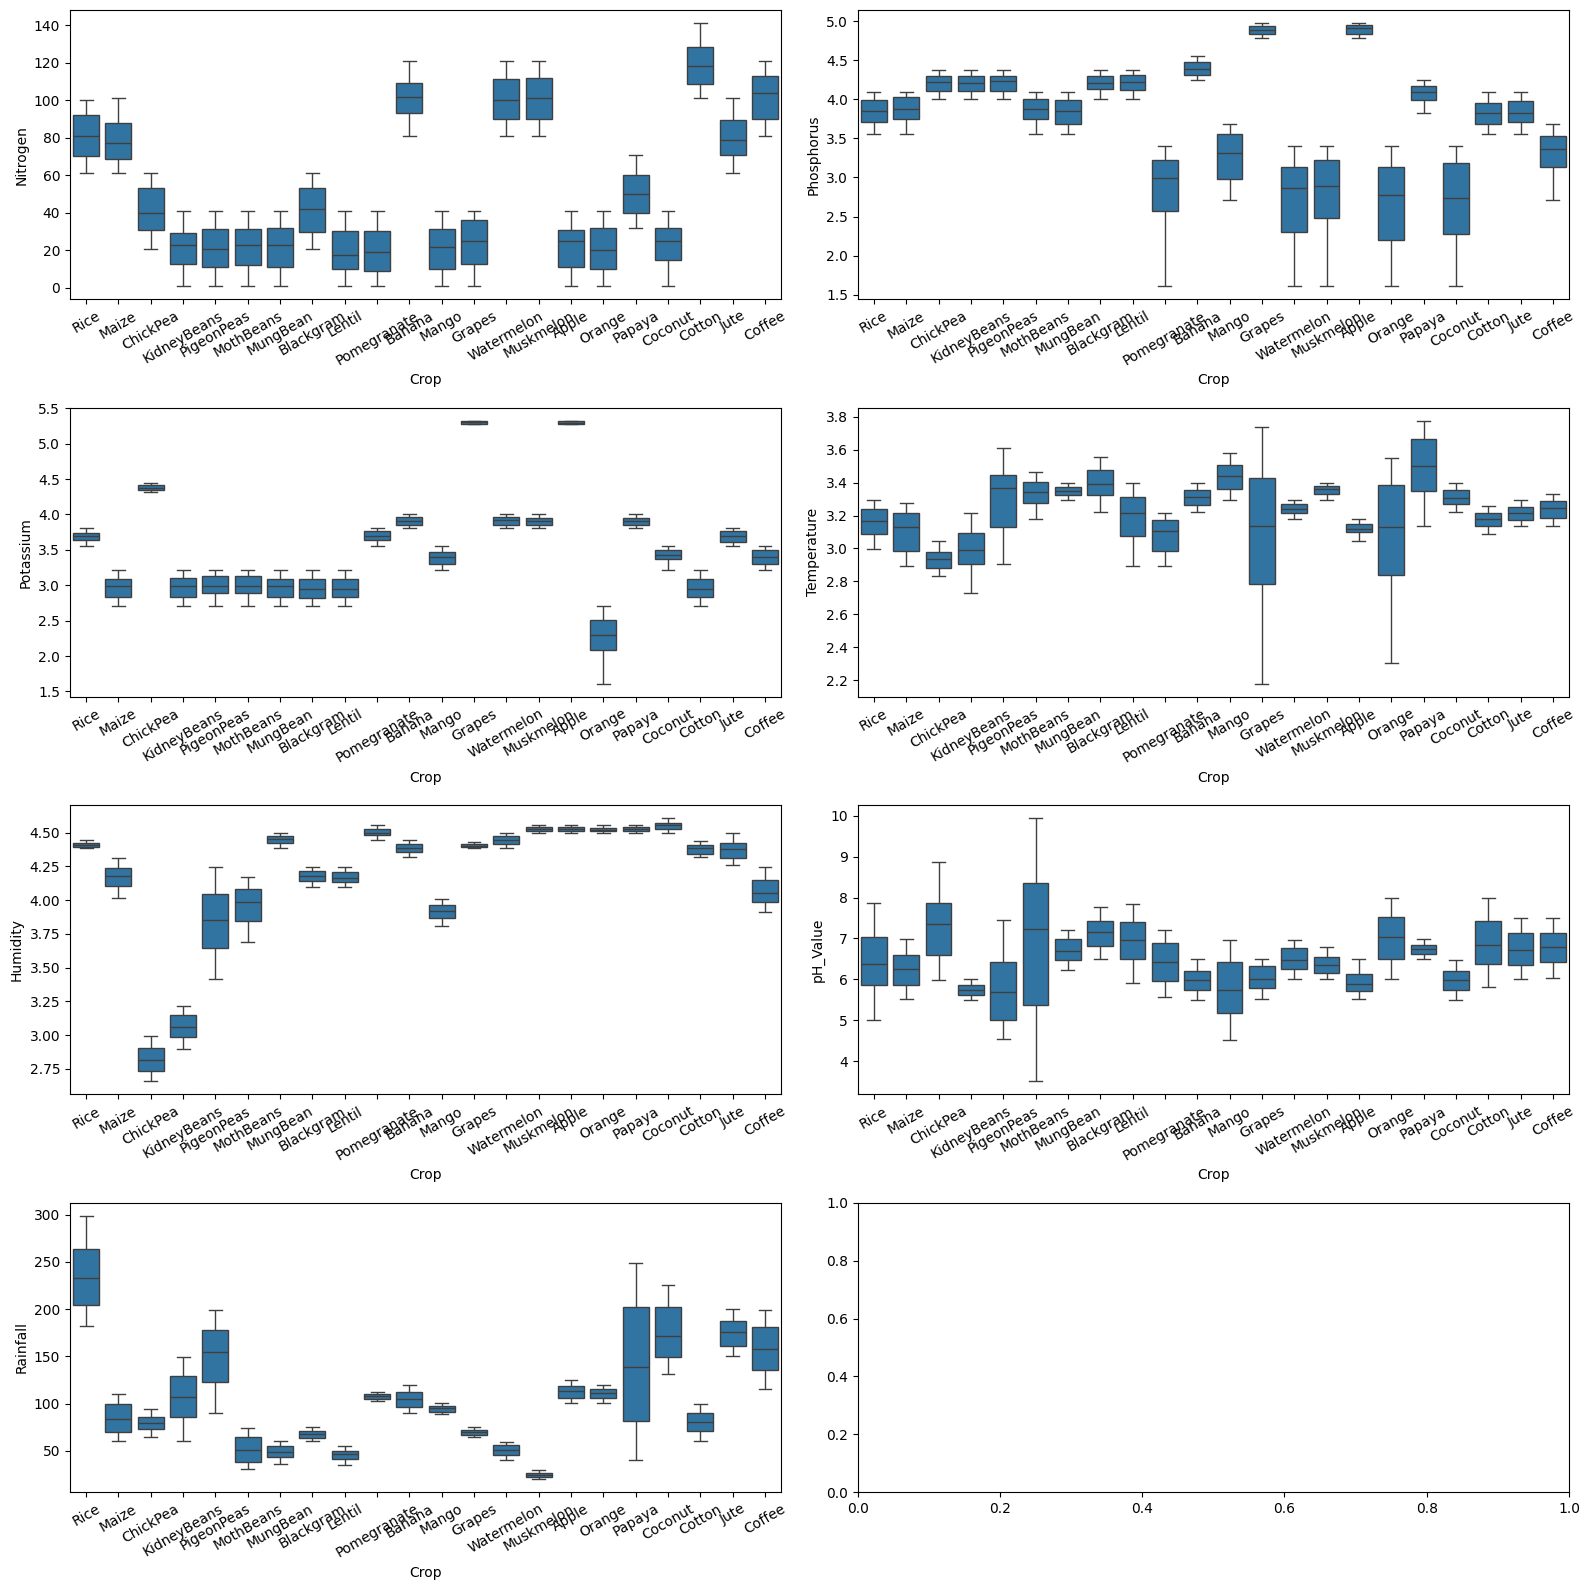

In [ ]:
n_cols = 2
n_rows = 4
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
ax = ax.flatten()

for i, feature in enumerate(features):
    sb.boxplot(data=a1, x=target, y=feature,ax=ax[i] )
    ax[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show(block=False)

##model building

In [33]:
def transform_data(df: pd.DataFrame, target: str, num_features: int = None):
    # Encoding target
    lbl_encoder = LabelEncoder()
    df[target+'_Encoded'] = lbl_encoder.fit_transform(df[target])
    
    # Assign features and labels
    x = df.drop([target, target+'_Encoded'], axis=1)
    y = df[target+'_Encoded']
    
    # Split the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
    
    # Access the encoded classes
    encoded_classes = lbl_encoder.classes_
    # Print the mapping (index corresponds to encoded value, value is the original label)
    for i, label in enumerate(encoded_classes):
        print(f"Encoded Value: {i}, Original Label: {label}")
    
    return x, y

In [24]:

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
def evaluate_models(X, y, models, cv=5):
    # Create a dictionary to store the results
    results = {
        'Model': [],
        'Accuracy Mean': [],
        'Accuracy Std': [],
        'Precision Mean': [],
        'Precision Std': [],
        'Recall Mean': [],
        'Recall Std': [],
        'F1 Score Mean': [],
        'F1 Score Std': []
    }
    for model in models:
        model_name = type(model).__name__
        results['Model'].append(model_name)
        
        # Perform cross-validation and compute metrics
        cv_results = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'])

        results['Accuracy Mean'].append(np.mean(cv_results['test_accuracy']))
        results['Accuracy Std'].append(np.std(cv_results['test_accuracy']))
        results['Precision Mean'].append(np.mean(cv_results['test_precision']))
        results['Precision Std'].append(np.std(cv_results['test_precision']))
        results['Recall Mean'].append(np.mean(cv_results['test_recall']))
        results['Recall Std'].append(np.std(cv_results['test_recall']))
        results['F1 Score Mean'].append(np.mean(cv_results['test_f1']))
        results['F1 Score Std'].append(np.std(cv_results['test_f1']))
    # Convert the results dictionary to a DataFrame for tabular display
    results_df = pd.DataFrame(results)
    return results_df

# Load data
data_for_ml = transform_data(df = a1, target='Crop')
# data_for_ml
X = data_for_ml[0]
y = data_for_ml[1]

# # List of models to evaluate
models = [GradientBoostingClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

# Evaluate models
results_df = evaluate_models(X, y, models)
print(results_df)

Encoded Value: 0, Original Label: Apple
Encoded Value: 1, Original Label: Banana
Encoded Value: 2, Original Label: Blackgram
Encoded Value: 3, Original Label: ChickPea
Encoded Value: 4, Original Label: Coconut
Encoded Value: 5, Original Label: Coffee
Encoded Value: 6, Original Label: Cotton
Encoded Value: 7, Original Label: Grapes
Encoded Value: 8, Original Label: Jute
Encoded Value: 9, Original Label: KidneyBeans
Encoded Value: 10, Original Label: Lentil
Encoded Value: 11, Original Label: Maize
Encoded Value: 12, Original Label: Mango
Encoded Value: 13, Original Label: MothBeans
Encoded Value: 14, Original Label: MungBean
Encoded Value: 15, Original Label: Muskmelon
Encoded Value: 16, Original Label: Orange
Encoded Value: 17, Original Label: Papaya
Encoded Value: 18, Original Label: PigeonPeas
Encoded Value: 19, Original Label: Pomegranate
Encoded Value: 20, Original Label: Rice
Encoded Value: 21, Original Label: Watermelon


c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\subha\AppData\Local\Programs\Python\Pyth

                        Model  Accuracy Mean  Accuracy Std  Precision Mean  \
0  GradientBoostingClassifier       0.990909      0.003214             NaN   
1      DecisionTreeClassifier       0.987273      0.003083             NaN   
2      RandomForestClassifier       0.994545      0.002318             NaN   

   Precision Std  Recall Mean  Recall Std  F1 Score Mean  F1 Score Std  
0            NaN          NaN         NaN            NaN           NaN  
1            NaN          NaN         NaN            NaN           NaN  
2            NaN          NaN         NaN            NaN           NaN  


c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\subha\AppData\Local\Programs\Python\Pyth

In [32]:
data_for_ml

In [26]:
X = a1[['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH_Value', 'Rainfall']]
y = a1['Crop']

In [28]:
X

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
0,90,3.737670,3.761200,3.038779,4.406753,6.502985,202.935536
1,85,4.060443,3.713572,3.080554,4.386014,7.038096,226.655537
2,60,4.007333,3.784190,3.135688,4.410623,7.840207,263.964248
3,74,3.555348,3.688879,3.276809,4.384004,6.980401,242.864034
4,78,3.737670,3.737670,3.002220,4.401889,7.628473,262.717340
...,...,...,...,...,...,...,...
2195,107,3.526361,3.465736,3.287455,4.195897,6.780064,177.774507
2196,99,2.708050,3.295837,3.311167,4.036651,6.086922,127.924610
2197,118,3.496508,3.401197,3.183530,4.208047,6.362608,173.322839
2198,117,3.465736,3.526361,3.268520,3.953691,6.758793,127.175293


In [29]:
y

0         Rice
1         Rice
2         Rice
3         Rice
4         Rice
         ...  
2195    Coffee
2196    Coffee
2197    Coffee
2198    Coffee
2199    Coffee
Name: Crop, Length: 2200, dtype: category
Categories (22, object): ['Apple', 'Banana', 'Blackgram', 'ChickPea', ..., 'PigeonPeas', 'Pomegranate', 'Rice', 'Watermelon']